<a href="https://colab.research.google.com/github/Shrishti18/Text-Summarization/blob/main/transformer_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This project demonstrates how to create and train a sequence-to-sequence Transformer model to translate Long News Document into Single News Headline(Summarization). The Transformer was originally proposed in "Attention is all you need" by Vaswani et al. (2017).**

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download shashichander009/inshorts-news-data


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.9/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.9/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import time
import re
import pickle

Inshorts is a news service that provides short summaries of news from around the web. This dataset contains headlines and summary of news items along with its source.



In [ ]:
news = pd.read_excel("Inshorts Cleaned Data.xlsx", sheet_name='Sheet1')
news.head()


,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...,Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...,YouTube,23:24:00,2017-03-25


In [ ]:
news.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)


In [ ]:
news.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [ ]:
news.shape


(55104, 2)

In [ ]:
text_document = news['Short']
summary = news['Headline']

In [ ]:
text_document[1]

'Chief Justice JS Khehar has said the Supreme Court will go paperless in six to seven months in a bid to save funds and make the judiciary eco-friendly. He further said the apex court will collect all the records electronically from the lower courts and the high courts so that there is no need to file hard copies.'

In [ ]:
summary[1]

'Supreme Court to go paperless in 6 months: CJI'

The goal of this project is to show how Transformers can be used for Text summarization.

In this tutorial you will:

1. Prepare the data.(*we will preprocess over the data*)

2. Implement necessary components:
a. Positional embeddings(*converting everysingle words into vectors specifically for text to text conversion*, 
b. Attention layers(*define BaseAttention, GlobalAttention, CasualselfAttention, CrossAttention* ),
c. The encoder and decoder(*combining AttentionLayers into Encoder and Decoder*).

3. Build & train the Transformer(*Training the Transformer model for Summarization use Optimization and Loss metrics for getting most minimize Loss and High Accuracy*).

4. Run inference,generate summarization.

5. Export the model.

The whole Transformer Model which we are gonna discuss 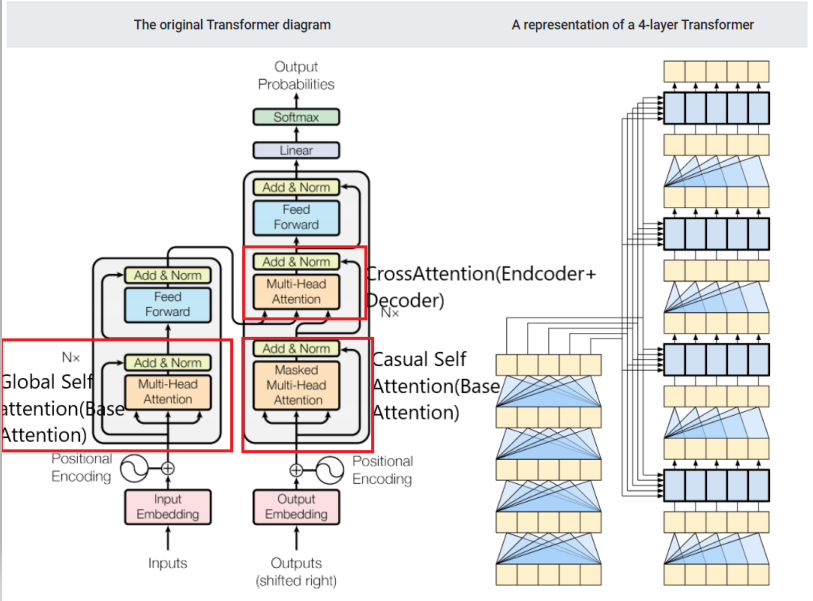

**1. Prepare the data**

We need to prepare the data so that our input vectors match perfectly with our transformer model and the model works perfectly well on Text summarization task



In [ ]:
# for decoder sequence
summary = summary.apply(lambda x: '<go> ' + x + ' <stop>')
summary.head()

0    <go> 4 ex-bank officials booked for cheating b...
1    <go> Supreme Court to go paperless in 6 months...
2    <go> At least 3 killed, 30 injured in blast in...
3    <go> Why has Reliance been barred from trading...
4    <go> Was stopped from entering my own studio a...
Name: Headline, dtype: object

In [ ]:
summary[1]

'<go> Supreme Court to go paperless in 6 months: CJI <stop>'

In [ ]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

In [ ]:
text_document_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)

In [ ]:
text_document_tokenizer.fit_on_texts(text_document)
summary_tokenizer.fit_on_texts(summary)

summary_tokenizer.texts_to_sequences(["This is a test"])
[[184, 22, 12, 71]]

summary_tokenizer.sequences_to_texts([[184, 22, 12, 71]])
['this is a test']

This is converting words into vectors 

In [ ]:
inputs = text_document_tokenizer.texts_to_sequences(text_document)
targets = summary_tokenizer.texts_to_sequences(summary)

The resulting values of encoder_vocab_size and decoder_vocab_size represent the total number of unique words in the input and output sequences respectively, including the "out of vocabulary" token. 

In [ ]:
encoder_vocab_size = len(text_document_tokenizer.word_index) + 1
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(76362, 29661)

In [ ]:
text_document_lengths = pd.Series([len(x) for x in text_document])
summary_lengths = pd.Series([len(x) for x in summary])
text_document_lengths.describe()


count    55104.000000
mean       368.003049
std         26.235510
min        280.000000
25%        350.000000
50%        369.000000
75%        387.000000
max        469.000000
dtype: float64

In [ ]:
summary_lengths.describe()

count    55104.000000
mean        63.620282
std          7.267463
min         20.000000
25%         59.000000
50%         63.000000
75%         69.000000
max         96.000000
dtype: float64

In [ ]:
encoder_maxlen = 400
decoder_maxlen = 75

*Padding/Truncating sequences*

By padding or truncating the sequences to a fixed length, we ensure that all input and output sequences have the same shape, which is required for training a neural network model. In particular, the input sequences will be fed into the encoder layer of a sequence-to-sequence model, while the output sequences will be fed into the decoder layer.

In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

Create a tf.data.Dataset: Use the tf.data.Dataset API to create a dataset object that can be used to feed data into the model during training. This involves chaining together a series of methods like from_tensor_slices, shuffle, and batch to create a pipeline that preprocesses the data and prepares it for training.

In [ ]:
inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)
BUFFER_SIZE = 20000
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

**2. Implementing Necessary Components** 


*Positional Embeddings*


Positional Encoding for adding notion of position among words as unlike RNN this is non-directional
So use this to create a PositionEmbedding layer that looks-up a token's embedding vector and adds the position vector:


In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

*Base Attention*

The querys is what you're trying to find.
The keys what sort of information the dictionary has.
The value is that information.
When you look up a query in a regular dictionary, the dictionary finds the matching key, and returns its associated value. The query either has a matching key or it doesn't. You can imagine a fuzzy dictionary where the keys don't have to match perfectly. If you looked up d["species"] in the dictionary above, maybe you'd want it to return "pickup" since that's the best match for the query.

# An attention layer does a fuzzy lookup like this, but it's not just looking for the best key. It combines the values based on how well the query matches each key.
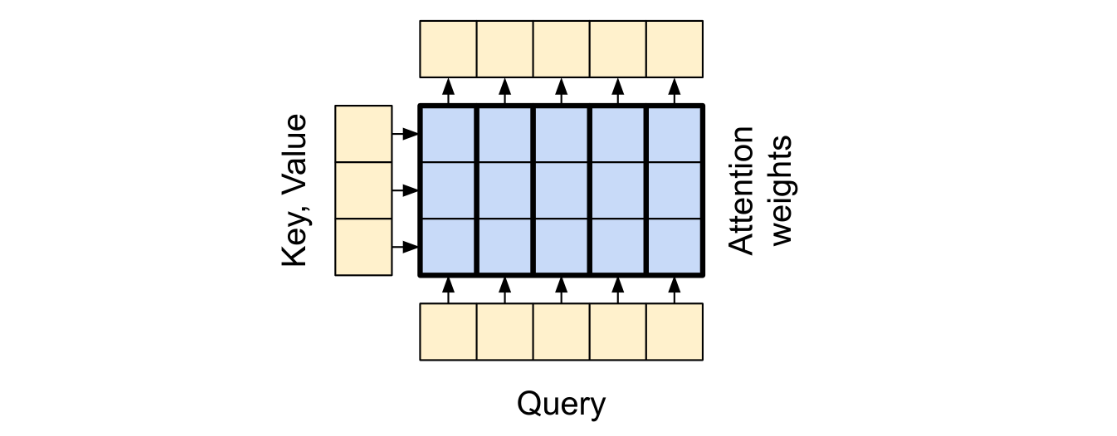

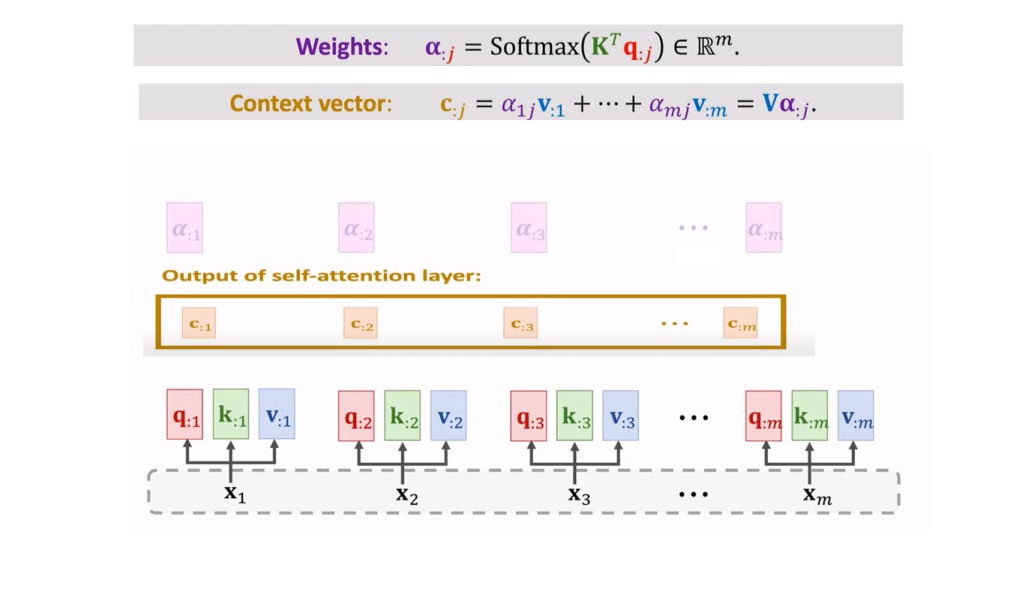

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

*Multi head attention*(global self attention)




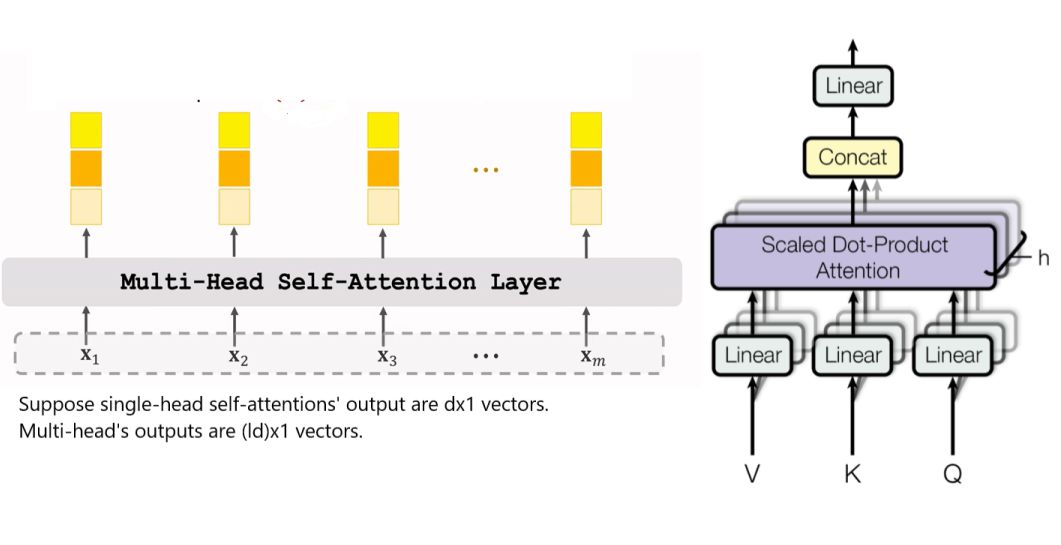

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        # split the x1 word vector into three k1,v1,q1
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

Feed Forward Network

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

Fundamental Unit of Transformer encoder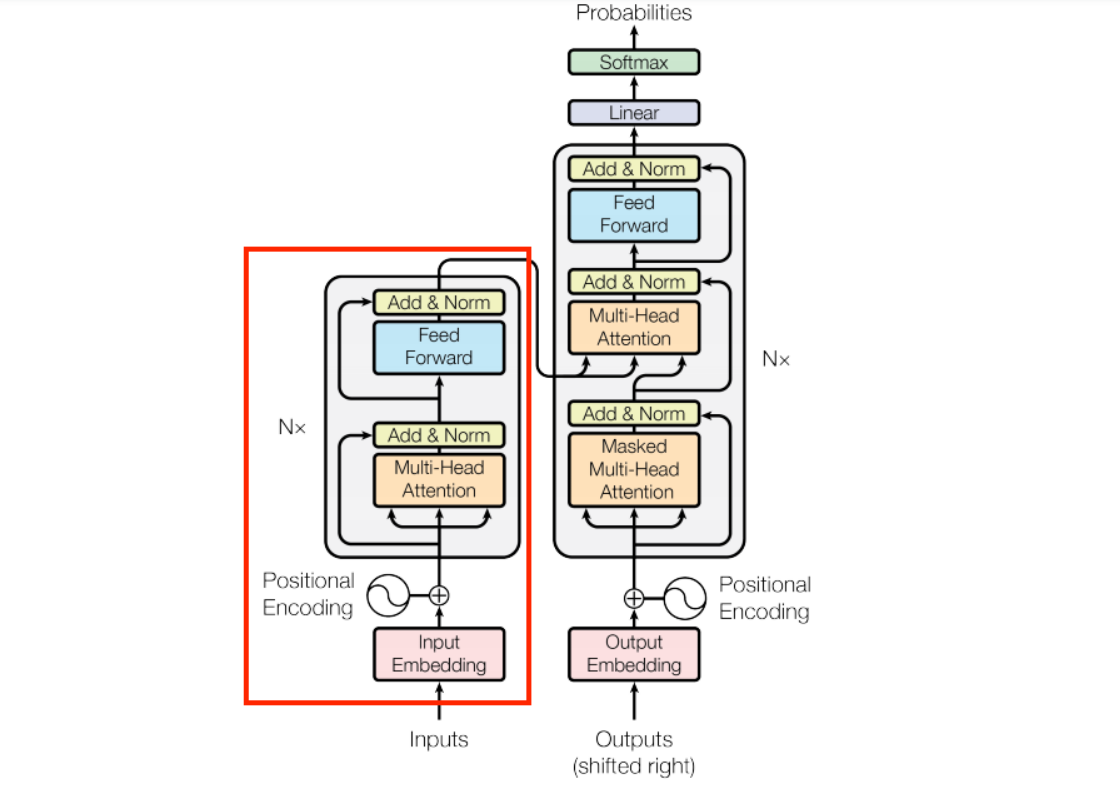

1. Add & Norm-The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are updated by the attention layers instead of replaced), while the normalization maintains a reasonable scale for the outputs.(*just like sigmoid function*)

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

Encoder consisting of multiple EncoderLayer(s)


In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x

*Cross attention*
 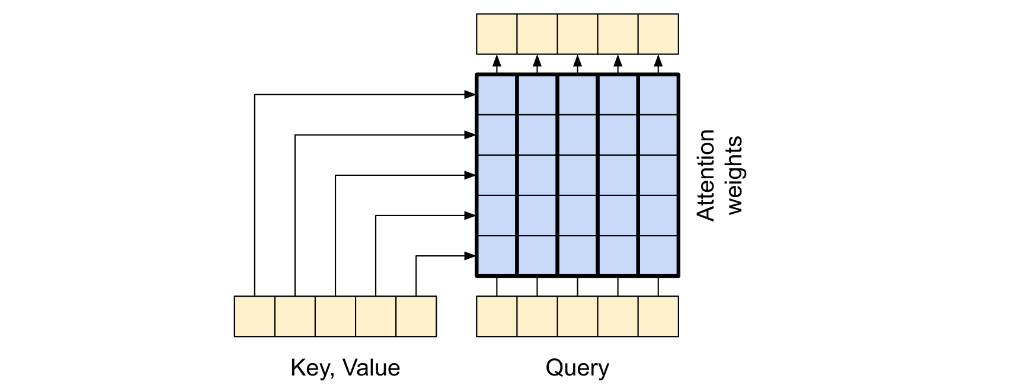


 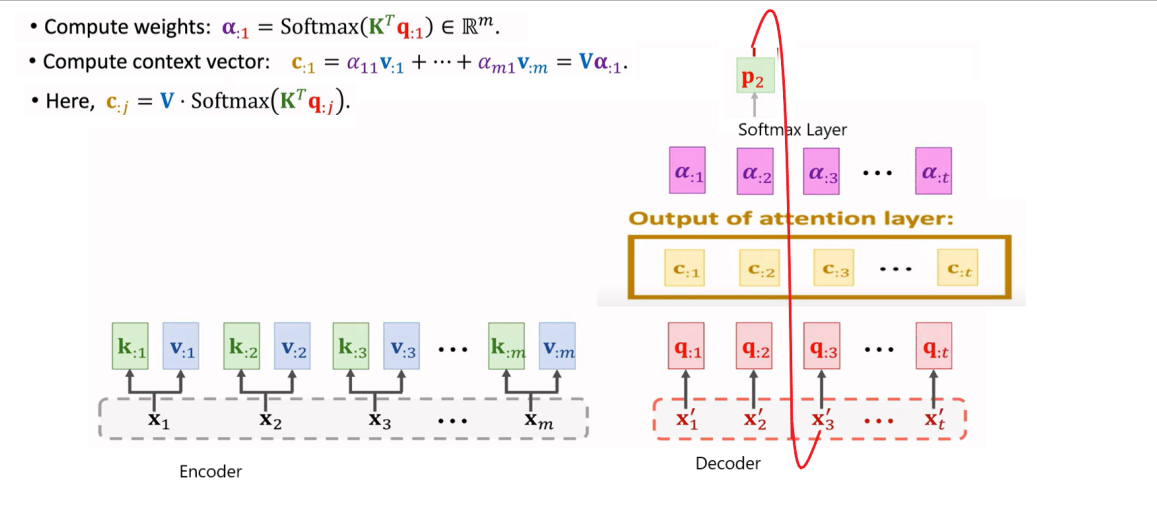




```
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x
    
```


Fundamental unit of Decoder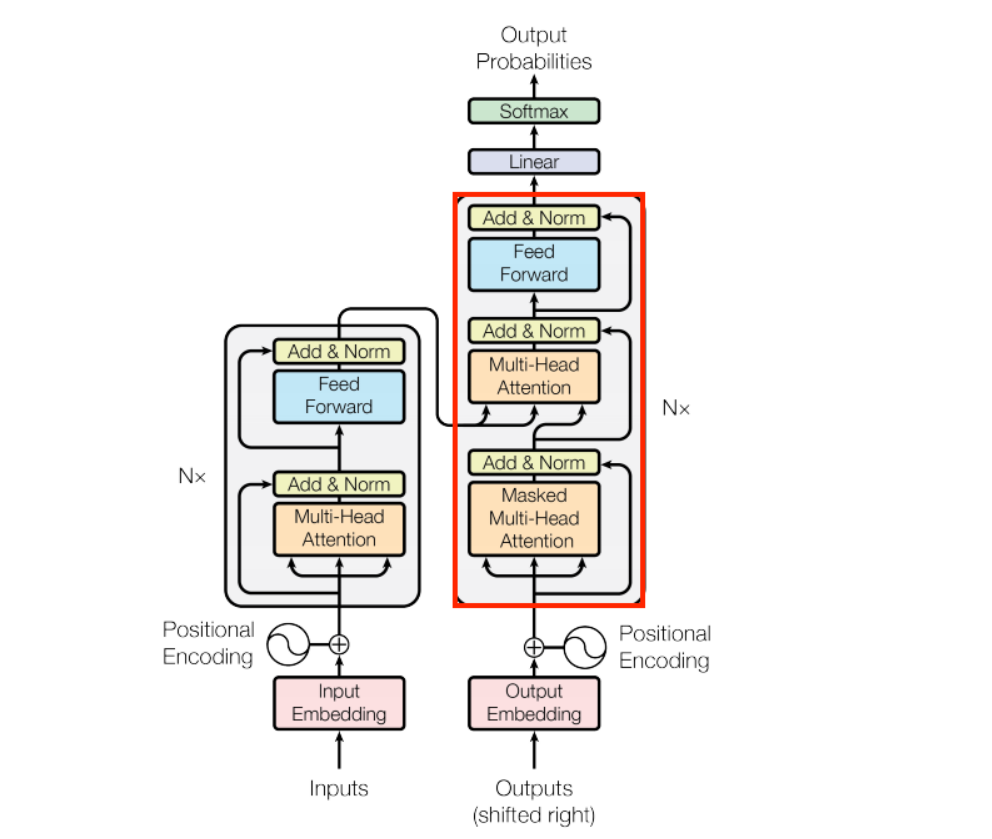

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

Decoder consisting of multiple DecoderLayer(s)


In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights

**3. Build the Model**
the Transformer



In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

num_layers: The number of layers in the Transformer model. Increasing this value can make the model more powerful, but also increases the risk of overfitting and slows down training.

d_model: The dimensionality of the model. This determines the size of the embedding vectors used to represent input data. Increasing this value can make the model more expressive, but also increases memory requirements and training time.

dff: The size of the feedforward network within each transformer block. Increasing this value can make the model more powerful, but also increases memory requirements and training time.

num_heads: The number of parallel attention heads used in the model. Increasing this value can make the model more effective at capturing complex relationships between inputs, but also increases memory requirements and training time.


In [ ]:
# hyper-params
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
EPOCHS = 20

Instantiate the Transformer model:

In [ ]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=encoder_vocab_size, 
    pe_target=decoder_vocab_size,
)

**3. Training**

 During the training process, the model is exposed to examples of input-output pairs, and it learns to map inputs to outputs by adjusting its parameters.

Optimization is a crucial part of the training process. The goal of optimization is to find the best set of parameters for the model that minimizes a certain loss function. The loss function measures the difference between the model's predictions and the actual output for each example in the training dataset. By minimizing the loss function, we are essentially trying to make the model's predictions as close to the true outputs as possible.

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
# Adam optimizer with its default paramters works best

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)



```
def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.cast(accuracies, dtype= tf.float32)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
```



In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')


Masking
Padding mask for masking "pad" sequences
Lookahead mask for masking future words from contributing in prediction of current words in self attention

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]
    
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

 It takes an input sequence and a target output sequence, generates predictions using the model, computes the loss between the true output sequence and the predicted output sequence, computes gradients using a gradient tape, updates the model's trainable variables using an optimizer, and records the training loss. This step can be repeated iteratively for multiple epochs to train the model on a dataset.

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        # 55k samples
        # we display 3 batch results -- 0th, middle and last one (approx)
        # 55k / 64 ~ 858; 858 / 2 = 429
        if batch % 429 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 10.3007
Epoch 1 Batch 429 Loss 9.1980
Epoch 1 Batch 858 Loss 8.2448
Epoch 1 Loss 8.2421
Time taken for 1 epoch: 395.52146673202515 secs

Epoch 2 Batch 0 Loss 7.0779
Epoch 2 Batch 429 Loss 6.8180
Epoch 2 Batch 858 Loss 6.6186
Epoch 2 Loss 6.6179
Time taken for 1 epoch: 335.5341691970825 secs

Epoch 3 Batch 0 Loss 6.3249
Epoch 3 Batch 429 Loss 6.0704
Epoch 3 Batch 858 Loss 5.9218
Epoch 3 Loss 5.9212
Time taken for 1 epoch: 333.9181044101715 secs

Epoch 4 Batch 0 Loss 5.6285
Epoch 4 Batch 429 Loss 5.5521
Epoch 4 Batch 858 Loss 5.4560
Epoch 4 Loss 5.4560
Time taken for 1 epoch: 332.7866313457489 secs

Epoch 5 Batch 0 Loss 5.2451
Epoch 5 Batch 429 Loss 5.1502
Epoch 5 Batch 858 Loss 5.0870
Saving checkpoint for epoch 5 at checkpoints/ckpt-1
Epoch 5 Loss 5.0864
Time taken for 1 epoch: 333.55740666389465 secs

Epoch 6 Batch 0 Loss 4.8696
Epoch 6 Batch 429 Loss 4.7708
Epoch 6 Batch 858 Loss 4.6995
Epoch 6 Loss 4.6993
Time taken for 1 epoch: 332.15812492370605 secs

Epoch 7 

**4. Run Inference**
Test the model for summarization.

In [ ]:
def evaluate(input_document):
    input_document = text_document_tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index["<go>"]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(decoder_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index["<stop>"]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


In [ ]:
def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # not printing <go> token
    return summary_tokenizer.sequences_to_texts(summarized)[0]  # since there is just one translated document

In [ ]:
summarize("Chief Justice JS Khehar has said the Supreme Court will go paperless \
 in six to seven months in a bid to save funds and make the judiciary eco-friendly.\
  He further said the apex court will collect all the records electronically from the lower courts \
  and the high courts so that there is no need to file hard copies."
)

'supreme court to go paperless in 6 months cji'

In [ ]:
summarize("The Central Bureau of Investigation (CBI) has registered a case against\
 Oxfam India and its office-bearers for allegedly violating the provisions of India's\
  foreign funding rules and carried out searches at the offices of the non-governmental organisation, officials said on Wednesday.")

'cbi registers case against cbi over corruption'